# Denoising models 

This model will take analyze and visualize predictions by the trained denoising models. 
### Define and load networks
First, we set up the network architecture and the IDs of the trained denoising models, which are used to load the network weights.

In [17]:
# Network architecture of the denoising models, currently only ResNetV1 is available
architecture = 'ResNetV1'
# IDs of the networks trained on either only generated data or only the original training data
network_id_alpha_0 = 'uqmoszis'
network_id_alpha_1 = '3q7b0j7s'

# GPU to use
gpu = "0"

Next, we import necessary packages and set the GPU

In [10]:
import sys
sys.path.append('../denoising')
sys.path.append('../metrics')

import os 
from models.ModelLoader import *

if not gpu is None:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)

tf.random.set_seed(2021)

The models and weights can be loaded as follows

In [11]:
input_dim = (None, None, 4)
model_alpha_0 = ModelLoader(id = network_id_alpha_0, architecture = architecture, input_dim = input_dim)
model_alpha_1 = ModelLoader(id = network_id_alpha_1, architecture = architecture, input_dim = input_dim)
model_alpha_0.restore(file=f'weights/{network_id_alpha_0}.h5')
model_alpha_1.restore(file=f'weights/{network_id_alpha_1}.h5')

dataKeys = {}

loading weights from weights/uqmoszis.h5
loading weights from weights/3q7b0j7s.h5


### Load data set
We define the data file and recreate the data splits that were used during training

In [12]:
# Location of the data file with SKIRT galaxies + PSF
DATA_FILE = '/mnt/data/denoising/TNG_channel_a64_sdss99_full_convolved_r0.h5'

import h5py
from sklearn.model_selection import train_test_split
from dataloader import *

with h5py.File(DATA_FILE, 'r') as f:
    train_keys, val_keys = train_test_split(list(f.keys()), test_size=0.4, train_size=0.6, random_state=2021, shuffle=True, stratify=None)
    val_keys, test_keys = train_test_split(val_keys, test_size=0.5, train_size=0.5, random_state=2021, shuffle=True, stratify=None)
    dataKeys['train'] = list(zip([DATA_FILE] * len(train_keys), train_keys))
    dataKeys['val'] = list(zip([DATA_FILE] * len(val_keys), val_keys))
    dataKeys['test'] = list(zip([DATA_FILE] * len(test_keys), test_keys))


batch_size = 1
testGenerator = DataLoader([DATA_FILE], dataKeys['test'], batch_size, name='test', shuffle=False)

Length: 2391


Exception ignored in: <bound method DataLoader.__del__ of <dataloader.DataLoader object at 0x7fd4d78c9588>>
Traceback (most recent call last):
  File "../denoising/dataloader.py", line 117, in __del__
    self.h5files.close()
AttributeError: 'dict' object has no attribute 'close'


### Define augmentations
The augmentations we use are defined as follows, see Section 6.3 in the paper for reference

In [13]:
augmentation_2 = {'snp' : 0.25, 'downsampling' : 2}
augmentation_3 = {'snp' : 0.05, 'downsampling' : 1}
augmentation_4 = {'snp' : 0.05, 'downsampling' : 2}

### Run denoising models

Run both models with and without the augmentations

In [14]:
from plot import predict_denoising_images

keys = dataKeys['test'][:10]

pictures_generated_noAug = predict_denoising_images(keys, testGenerator, model_alpha_1, augmentation=None)
pictures_generated_Aug2 = predict_denoising_images(keys, testGenerator, model_alpha_1, augmentation=augmentation_2)
pictures_generated_Aug3 = predict_denoising_images(keys, testGenerator, model_alpha_1, augmentation=augmentation_3)
pictures_generated_Aug4 = predict_denoising_images(keys, testGenerator, model_alpha_1, augmentation=augmentation_4)

pictures_source_noAug = predict_denoising_images(keys, testGenerator, model_alpha_0, augmentation=None)
pictures_source_Aug2 = predict_denoising_images(keys, testGenerator, model_alpha_0, augmentation=augmentation_2)
pictures_source_Aug3 = predict_denoising_images(keys, testGenerator, model_alpha_0, augmentation=augmentation_3)
pictures_source_Aug4 = predict_denoising_images(keys, testGenerator, model_alpha_0, augmentation=augmentation_4)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

Now plot the results. This will recreate Figure 9 from the paper

/home/benjamin/projects/galaxies-metrics-denoising/notebooks/plot.py:403: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


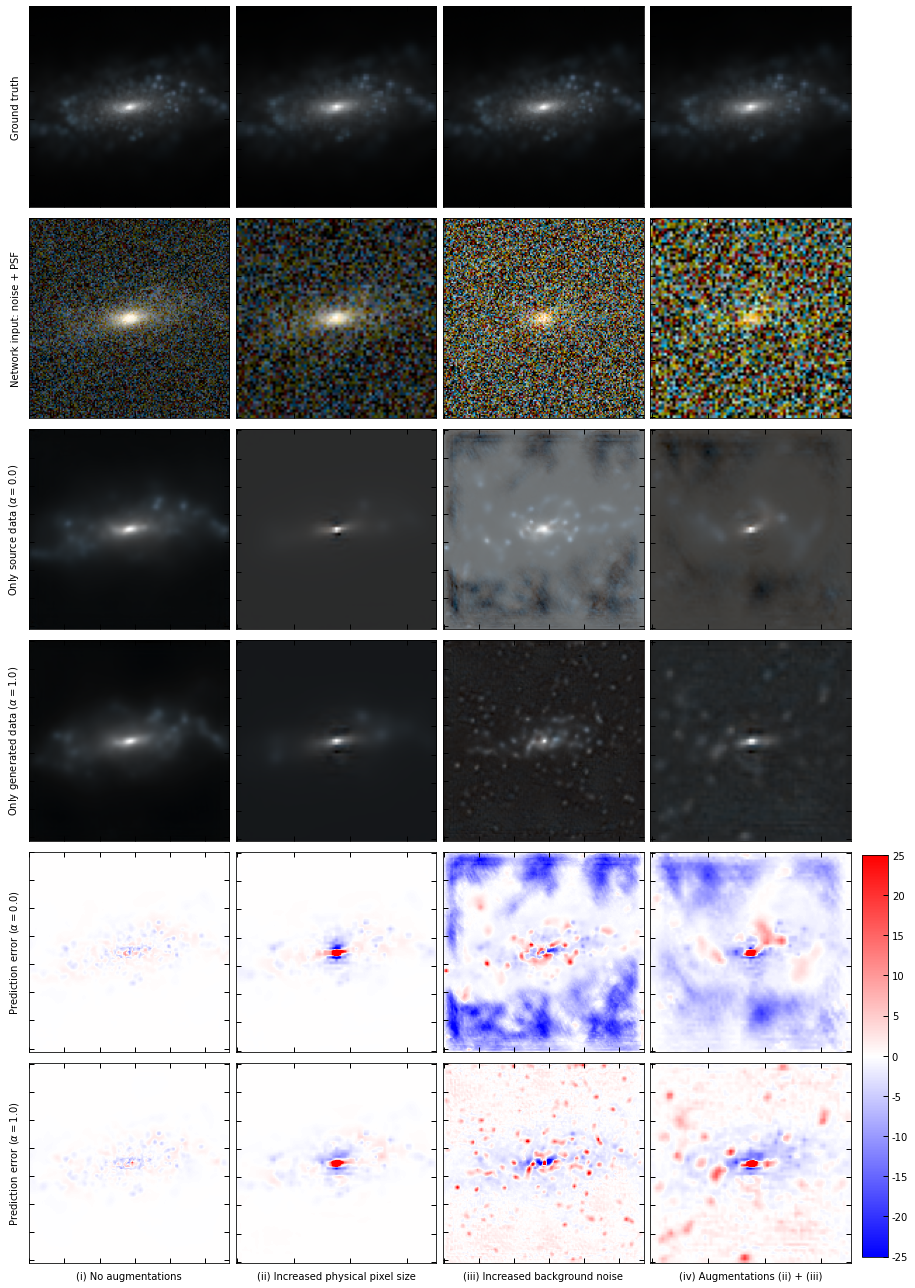

In [15]:
from plot import plot_denoising_example 
from matplotlib import pyplot as plt

idx = 1
data_generated = (pictures_generated_noAug, pictures_generated_Aug2, pictures_generated_Aug3, pictures_generated_Aug4)
data_source = (pictures_source_noAug, pictures_source_Aug2, pictures_source_Aug3, pictures_source_Aug4)

plot_denoising_example(data_source, data_generated, index=idx)
plt.show()